In [58]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [59]:
import numpy as np
from math import ceil, floor
import regions
import astropy as ast
import matplotlib.pyplot as plt
from astropy.nddata import block_reduce
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import FlatLambdaCDM
from matplotlib.colors import LogNorm
from astropy.io import fits

In [60]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 8)

# Step 0: Setting the stage

We are interested in developing a method of projecting and dimming a galaxy of known redshift.

In order to do so we need the following equation for the Surface Brightness Dimming :
 
$$ B \sim \frac{1}{z^4 + 1} $$

For the angular distance one could incorrectly use:
$$
\dfrac{ \theta(z_2)}{ \theta(z_1)} =    \dfrac{ (1+z_2)\, D_{\rm_{com}}(z_1)}{(1+z_1)\, D_{\rm_{com}}(z_2)},    
$$
where $D_{\rm_{com}}$ the comoving distance. And number of pixels $n(z)$ : $n \sim l \sim \theta$. However, as can be seen in Appendix A, there are discrepancies between this approach and the correct one using a cosmological library.

We will do this by examining the case of NGC3982, a spiral galaxy with $z_{\rm{known}}=z_0=0.00371$ and projecting it to z=3.

Throughout this notebook we assume that the intensity of each pixel corresponds to an arbitary flux unit which we will not discuss further.

Below we start by displaying the entirity of the image.

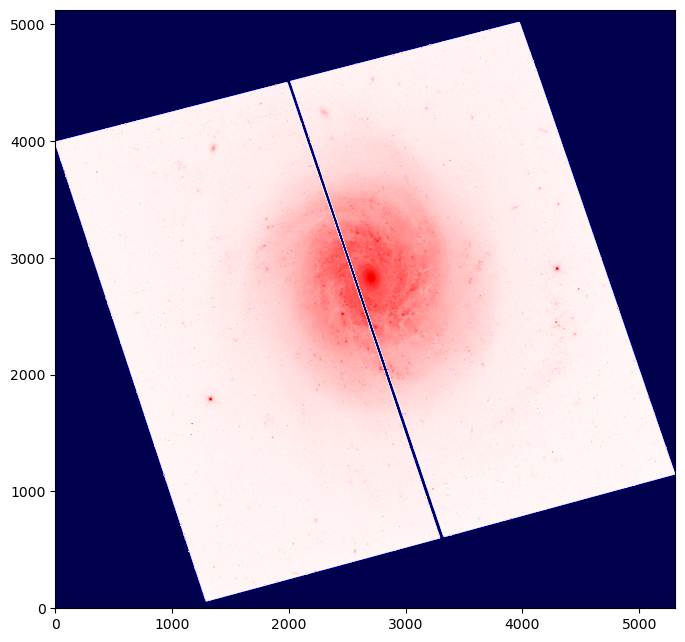

In [61]:
z = 3
z_0 = 0.00371

hdul = fits.open("hst_11570_22_wfc3_uvis_total_drz.fits")
image = hdul[1].data
plt.imshow(image, norm=LogNorm(), cmap='seismic', origin='lower')

# Step 1: Image section choice

In order to process the data, we will need a way to display and cut out the part of the image that is of interest to us (i.e. the galaxy) as well as a way to examine the background noise.

In [62]:
def examine_image(image, region=np.s_[:, :], display=True):
    cut_image = image[region]
    print(np.mean(cut_image))
    if display:
        plt.imshow(cut_image, norm=LogNorm(), origin='lower', cmap='seismic')
        plt.colorbar()
    return cut_image

In [63]:
def bg_noise(image, noise_center, noise_width, noise_height, display=True):

    noise_region = regions.RectanglePixelRegion(center=regions.PixCoord(
        *noise_center), width=noise_width, height=noise_height)

    noise_mask = noise_region.to_mask()
    noise_cutout = noise_mask.cutout(image)

    noise_mean = np.mean(noise_cutout)
    noise_std = np.std(noise_cutout)
#     print(f"The background mean intensity is : {noise_mean}")

    if display:
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(12, 12)
        ax[1].imshow(noise_cutout, norm=LogNorm(),
                     origin='lower', cmap='seismic')
        ax[0].imshow(image, norm=LogNorm(vmin=noise_mean, vmax=8),
                     origin='lower', cmap='seismic')  # vmax has been chosen in such a way that allows us o easily see the galaxy structure
        noise_region.plot(ax=ax[0], color='green')

    return noise_mean, noise_std

0.11015156


(2200, 2100)

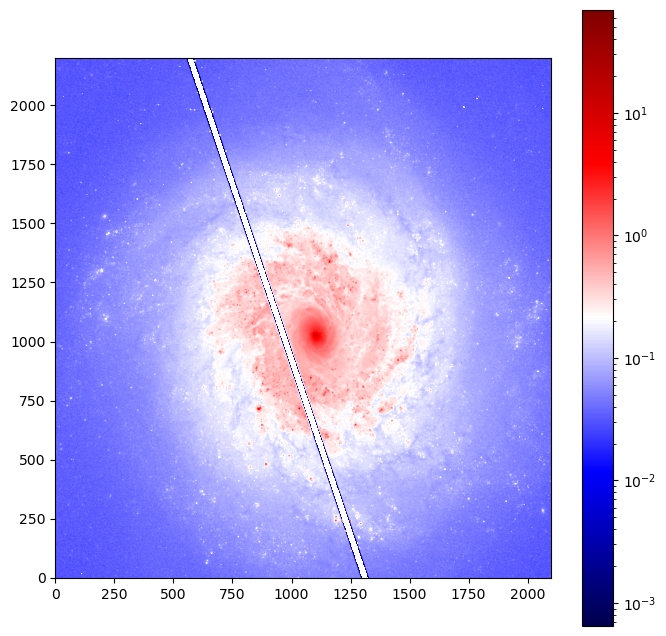

In [64]:
# _ = examine_image(image) # Shows the whole image again

galaxy = examine_image(image, np.s_[1800:4000, 1600:3700])
# Numbers have been found by "playing around" until suitable pairs had been found.
# Automatation of this proccess is beyond the scope of this project
np.shape(galaxy)

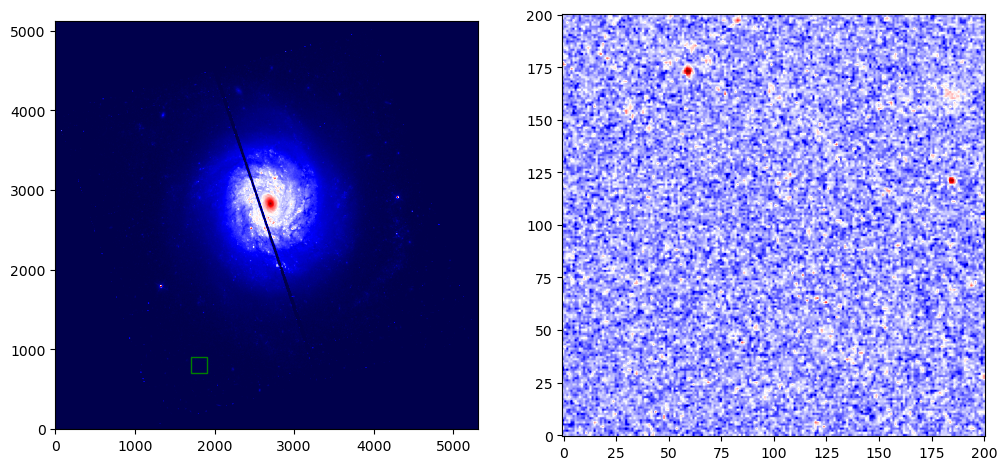

In [65]:
# numbers again have been found by testing
noise_data = bg_noise(image, [1800, 800], 200, 200)

# Step 2: Resizing our Galaxy by rebining

In [66]:
def scaling_factor_wrong(z=z, z_0=z_0):
    D_0 = cosmo.comoving_distance(z_0)
    D = cosmo.comoving_distance(z)
    scale = ((1+z)*D_0)/((1+z_0)*D)
    return scale


model = FlatLambdaCDM(H0=70, Om0=0.3)


def scaling_factor(z=z, z_0=z_0):
    scale = model.arcsec_per_kpc_proper(z)/cosmo.arcsec_per_kpc_proper(z_0)
    return scale


# With the help of chatgpt we can rebin an array while conserving its sum as follows:


def rebin_array(arr, new_shape):
    a, b = arr.shape
    n, m = new_shape

    # Calculate the scaling factors
    scale_factor_a = a / n
    scale_factor_b = b / m

    # Initialize the rebinned array with zeros
    rebinned_arr = np.zeros(new_shape)

    # Loop over the old array elements and add them to the corresponding bin in the rebinned array
    for i in range(a):
        for j in range(b):
            new_i = int(i / scale_factor_a)
            new_j = int(j / scale_factor_b)
            rebinned_arr[new_i, new_j] += arr[i, j]

    return rebinned_arr


def resize_for_z(image, z=z, z0=z_0, display=True):
    scale = scaling_factor()
    X_0, Y_0 = image.shape
    X_z, Y_z = ceil(scale * X_0), ceil(scale * Y_0)

    resized = rebin_array(image, (X_z, Y_z))

    print(f"Our new dimensions are {resized.shape}")
    print(f"Flux /Resized Flux = {np.sum(image)/np.sum(resized)}")

    if display:
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(12, 12)

        ax[0].imshow(resized, norm=LogNorm(),
                     origin='lower', cmap='seismic')
        ax[1].imshow(image, norm=LogNorm(),
                     origin='lower', cmap='seismic')  # LogNorm arguents are default for a better comparison

        ax[0].set_title("Resized Galaxy")
        ax[1].set_title("Original Galaxy")
    return resized

Our new dimensions are (23, 22)
Flux /Resized Flux = 0.9999998326209076


(23, 22)

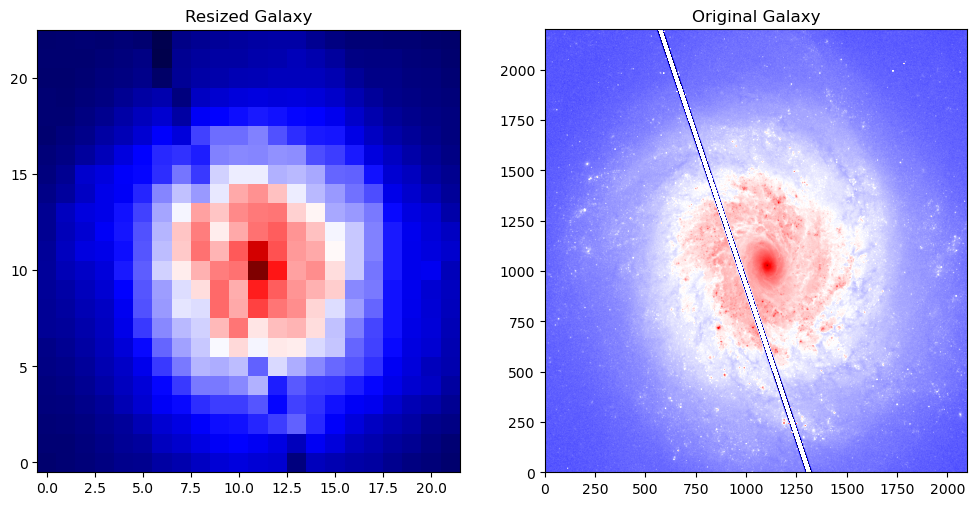

In [67]:
resized = resize_for_z(galaxy)
resized.shape

# Step 3 : Dimming the resized Galaxy and adding noise

In [68]:
def attenuation(image, z=z, z_0=z_0):

    dimmed = image * (((1+z_0)**4)/((1+z)**4))

    return dimmed

In [69]:
# dimmed = attenuation(resized)

In [70]:
def add_noise(image, resized):
    x, y = image.shape
    x_z, y_z = resized.shape
    final = np.random.normal(
        loc=noise_data[0], scale=noise_data[1], size=image.shape)  # Only noise
    final[(x-x_z)//2:(x+x_z)//2, (y-y_z)//2:(y+y_z) //
          2] += attenuation(resized)  # Galaxy at the center of noise
    final_zoomed = final[(x-x_z)//2:(x+x_z)//2, (y-y_z)//2:(y+y_z)//2]
    return final, final_zoomed

In [71]:
final, final_zoomed = add_noise(galaxy, resized)

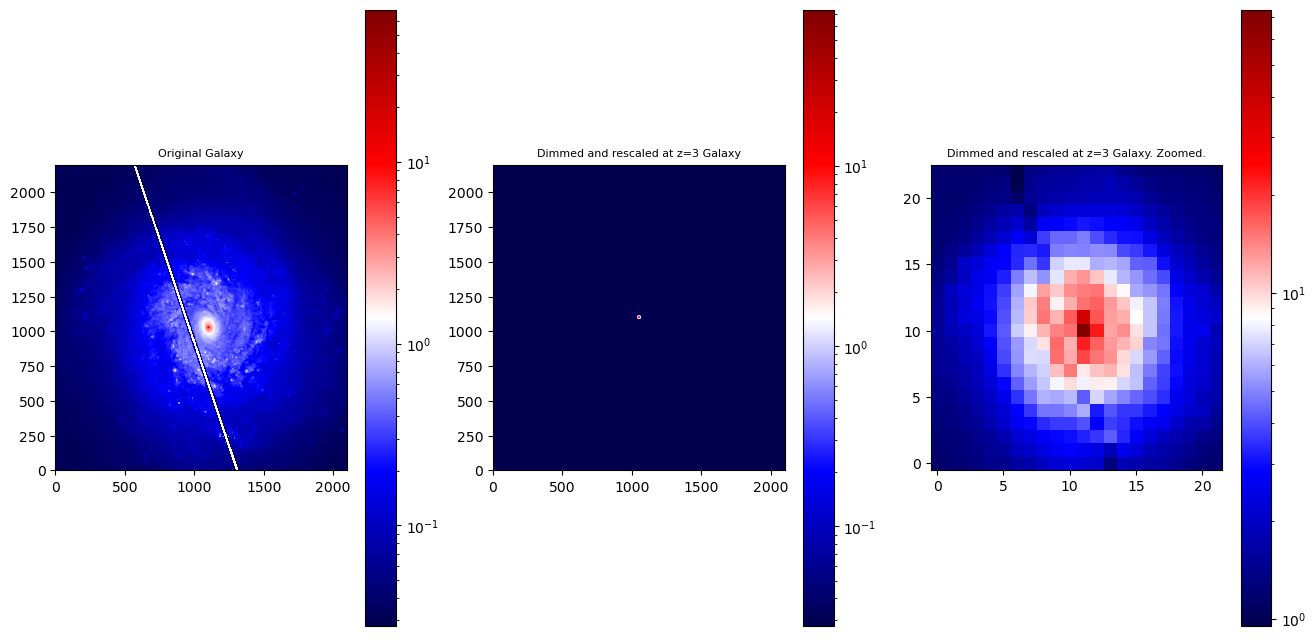

In [72]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(16, 16)

OG_plot = ax[0].imshow(galaxy, norm=LogNorm(
    vmin=noise_data[0]), origin='lower', cmap='seismic')
final_plot = ax[1].imshow(final, norm=LogNorm(
    vmin=noise_data[0]), origin='lower', cmap='seismic')
final_zoomed_plot = ax[2].imshow(
    final_zoomed, norm=LogNorm(), origin='lower', cmap='seismic')

ax[0].set_title("Original Galaxy", fontsize=8)
ax[1].set_title("Dimmed and rescaled at z=3 Galaxy", fontsize=8)
ax[2].set_title("Dimmed and rescaled at z=3 Galaxy. Zoomed.", fontsize=8)

plt.colorbar(OG_plot, ax=ax[0], shrink=0.5)
plt.colorbar(final_plot, ax=ax[1], shrink=0.5)
plt.colorbar(final_zoomed_plot, ax=ax[2], shrink=0.5)

# Appendix A: Angular distance discrepancy

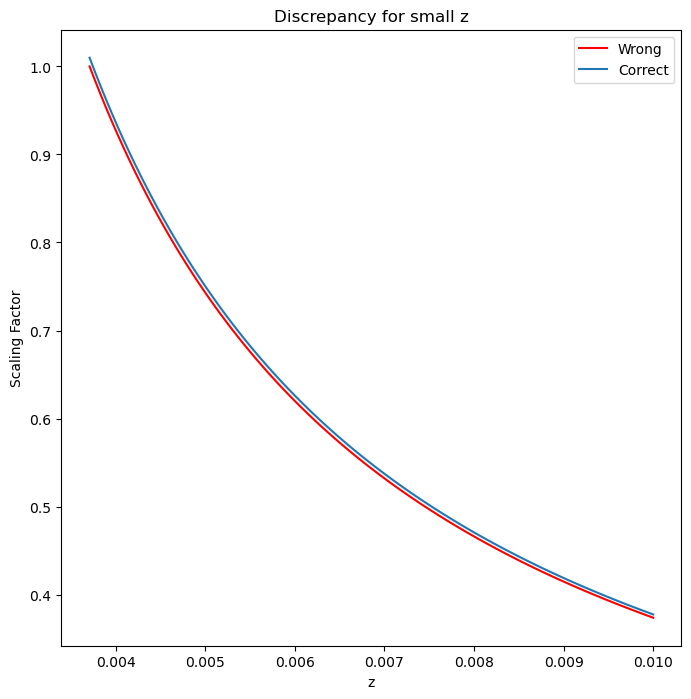

In [109]:
z_vec = np.linspace(z_0, 0.01, 100)
wrong = scaling_factor_wrong(z_vec)
correct = scaling_factor(z_vec)
plt.plot(z_vec, wrong, "r", label="Wrong")
plt.plot(z_vec, correct, label="Correct")
plt.legend()
plt.ylabel("Scaling Factor")
plt.xlabel("z")
plt.title("Discrepancy for small z")
plt.show()

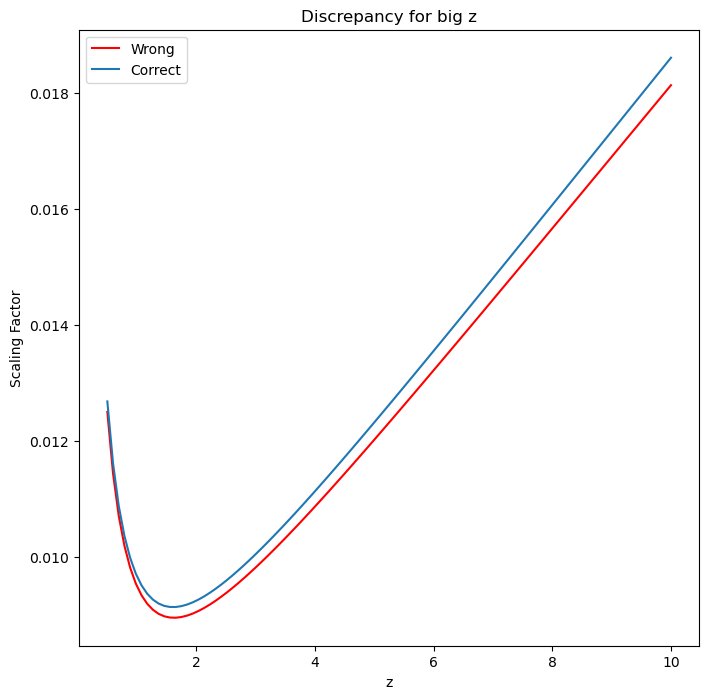

In [110]:
z_vec = np.linspace(0.5, 10, 100)
wrong = scaling_factor_wrong(z_vec)
correct = model.arcsec_per_kpc_proper(z_vec)/cosmo.arcsec_per_kpc_proper(z_0)
plt.plot(z_vec, wrong, "r", label="Wrong")
plt.plot(z_vec, correct, label="Correct")
plt.legend()
plt.ylabel("Scaling Factor")
plt.xlabel("z")
plt.title("Discrepancy for big z")
plt.show()